# 多値分類

### 多値分類の概要

多値分類は、n入力m出力の問題を解く手法です。今回は、2入力3出力の問題を考えます。多値分類では、重み行列、softmax関数、交差エントロピー関数を用いてパラメータを更新します。

1. 重み行列

2入力3出力の問題では、3x2の重み行列を使用します。この重み行列と入力ベクトルの積を計算して、それぞれのクラスに対するスコアを得ます。

$$
Z = WX + B
$$

ここで、$Z$はスコアベクトル、$X$は入力ベクトル、$W$は重み行列、$B$はバイアスベクトルです。

2. softmax関数

softmax関数は、スコアベクトルを確率分布に変換する関数です。各クラスに属する確率を求めるために使用します。

$$
P_i = \frac{e^{z_i}}{\sum_{j=1}^{3} e^{z_j}}
$$

3. 交差エントロピー関数

多値分類では、交差エントロピー関数を損失関数として使用します。この関数は、予測確率分布と実際のラベルの確率分布との間の距離を計算します。なお、ラベルの確率分布とはある一つのクラスに属する確率が100％で他のクラスの属する確率は0％なので、$y_i$は正解のときだけ1で他のときは0になる関数と思って問題ありません。

$$
L = -\sum_{i=1}^{3} y_i \log p_i
$$

4. パラメータの更新

損失関数を最小化するように、パラメータ$W$と$B$を更新します。勾配降下法を用いて、損失関数の勾配に従ってパラメータを更新します。

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$

$$
B \leftarrow B - \eta \frac{\partial L}{\partial B}
$$

ここで、$\eta$は学習率です。

5. PyTorchを使った実装

PyTorchを使って多値分類を実装する際には、以下のステップがあります:
   1. データの準備
   2. モデルの定義
   3. 損失関数と最適化アルゴリズムの選択
   4. モデルの学習
   5. モデルの評価
   
となります。

6. Pytorchの注意点

本来は以下の流れで学習を行う。
   1. $X_2 = WX_1 + B$ //予測関数の処理
   2. $X_3 = P_i(X_2)$ //予測関数の処理
   3. $X_4 = L(X_3)$ //損失関数の処理
   4. パラメータ更新

しかし、Pytorchではsoftmax関数と交差エントロピー関数は組み合わせて一つの損失関数として提供されています。よって
   1. $X_2 = WX_1 + B$ //予測関数の処理
   2. $X_3 = P_i(X_2)$ //損失関数の処理
   3. $X_4 = L(X_3)$ //損失関数の処理
   4. パラメータ更新
となるので混乱しないように注意する必要があります。

In [1]:
import numpy as np          # 数値計算ライブラリ
import matplotlib.pyplot as plt    # グラフ描画ライブラリ
import torch                 # 機械学習ライブラリPyTorch
from torch import nn        # PyTorchのニューラルネットワークモジュール
from torchviz import make_dot      # PyTorchのグラフ可視化ツール
import japanize_matplotlib  # matplotlibの日本語表示を可能にするライブラリ
import torch.optim as optim # PyTorchの最適化アルゴリズムを定義するoptimモジュール
import pandas as pd         # データフレーム処理のためのライブラリ
import sklearn              # 機械学習ライブラリscikit-learn
from torchinfo import summary   # モデルのサマリー情報を表示するためのライブラリ
from sklearn.model_selection import train_test_split  # データのトレーニングとテストの分割を行う関数
from sklearn.metrics import accuracy_score   # 正解率を計算するための関数


# 以下可視性のために定義。
import inspect # フレームを取得するためのライブラリ
from IPython.display import display # データフレームを表示するためのライブラリ

# 引数の変数名を出力する変数。ただし仕様上、関数を呼び出した場所と同スコープの変数なら1。その一個上なら2，さらにひとつ上なら3にしなければならない。
def print_var_name(var,n=1):
    # 現在のフレームを取得する
    current_frame = inspect.currentframe()
    # 現在のフレームのn回外側のフレームを取得する
    outer_frame = current_frame
    for _ in range(n):
        outer_frame =outer_frame.f_back
    # 外側のフレームのローカル変数を取得する。2次元タプル?がずらっと配列で並んでいる。
    locals_dict = outer_frame.f_locals
    # 変数名を取得する
    var_name = [k for k, v in locals_dict.items() if v is var]
    if not var_name:
        print("変数が見つかりませんでした。")
    else:
        # 変数名を出力する
        print("変数名 : ",var_name[0]," 変数型は ",type(var))

def dataframe_converter(func):
    def wrapper(*args, **kwargs):
        for arg in args:
            
            try:
                print("形状は",arg.shape)
            except:
                pass

            try:
                # 引数がNumPy配列の場合はPandasデータフレームに変換する
                print_var_name(arg,2)
                if isinstance(arg, np.ndarray):
                    df = pd.DataFrame(arg)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, torch.Tensor):
                    df = pd.DataFrame(arg.detach().numpy())
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                elif isinstance(arg, sklearn.utils.Bunch):
                    df = pd.DataFrame(arg.data, columns=arg.feature_names)
                    # デコレータで修飾された関数にデータフレームを渡す
                    func(df)
                else:
                    # デコレータで修飾された関数にそのままのオブジェクトを渡す
                    func(arg)
            except:
                # デコレータで修飾された関数にそのままのオブジェクトを渡す
                func(arg)
    return wrapper

@dataframe_converter
def display_custom(obj,head=True): # 引数のオブジェクトを表示する。可視性を高めるためにpdに変更するがおそらく大規模の場合は乱用はパフォーマンスに影響する。
    # 引数のオブジェクトを表示する
    if head and isinstance(obj, pd.DataFrame):
        display(obj.head())
        
    else:
        display(obj)

In [2]:
#変数名はできる限り短いプレフィックスを使用する。
#np_をnumpy配列、df_をデータフレーム、t_をテンソル、b_をsklearn.utils.Bunchとする。

## 1. データの準備

In [3]:
# アイリスデータセットの読み込み
from sklearn.datasets import load_iris
# アイリスのデータセットを読み込む
b_iris = load_iris()

# データフレームに変換する
df_iris = pd.DataFrame(data=b_iris.data, columns=b_iris.feature_names)

# アイリスの種類を追加する
df_iris['iris kind'] = b_iris.target

# アイリスの名前を表す列を追加する。applyメソッドは引数に関数を取り、各要素に対して関数を適用する。
# lambdaは無名関数を定義する。xは引数。if文は三項演算子と同じ。
df_iris['iris name'] = df_iris['iris kind'].apply(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')
# 結果を表示する
display_custom(df_iris)


形状は (150, 6)
変数名 :  df_iris  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),iris kind,iris name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [4]:
# 入力データと正解ラベルを作成する
# 入力データを作成する
df_x_org = df_iris.drop(columns=['iris kind','iris name'], axis=1)
# 今回は入力データは2次元配列にするため、'sepal length (cm)'と'petal length (cm)'の2列のみを使用する。
df_x = df_x_org.drop(columns=['sepal width (cm)','petal width (cm)'],axis=1)
# 正解ラベルを作成する
df_y = df_iris[['iris kind']]
display_custom(df_x)
display_custom(df_y)

形状は (150, 2)
変数名 :  df_x  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4


形状は (150, 1)
変数名 :  df_y  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
0,0
1,0
2,0
3,0
4,0


In [5]:
# データをトレーニングデータとテストデータに分割する
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.5, random_state=125)
display_custom(df_x_train,df_x_test,df_y_train,df_y_test)

形状は (75, 2)
変数名 :  df_x_train  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),petal length (cm)
120,6.9,5.7
106,4.9,4.5
119,6.0,5.0
97,6.2,4.3
84,5.4,4.5


形状は (75, 2)
変数名 :  df_x_test  変数型は  <class 'pandas.core.frame.DataFrame'>


,sepal length (cm),petal length (cm)
32,5.2,1.5
138,6.0,4.8
116,6.5,5.5
98,5.1,3.0
52,6.9,4.9


形状は (75, 1)
変数名 :  df_y_train  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
120,2
106,2
119,2
97,1
84,1


形状は (75, 1)
変数名 :  df_y_test  変数型は  <class 'pandas.core.frame.DataFrame'>


,iris kind
32,0
138,2
116,2
98,1
52,1


In [6]:
# データをテンソルに変換するためにnumpy配列に変換する
np_x_train = df_x_train.values
np_y_train = df_y_train.values
np_x_test = df_x_test.values
np_y_test = df_y_test.values

# データをテンソルに変換する
t_x_train = torch.tensor(np_x_train).float()
t_x_test = torch.tensor(np_x_test).float()
t_y_train = torch.tensor(np_y_train).long()
t_y_test = torch.tensor(np_y_test).long()

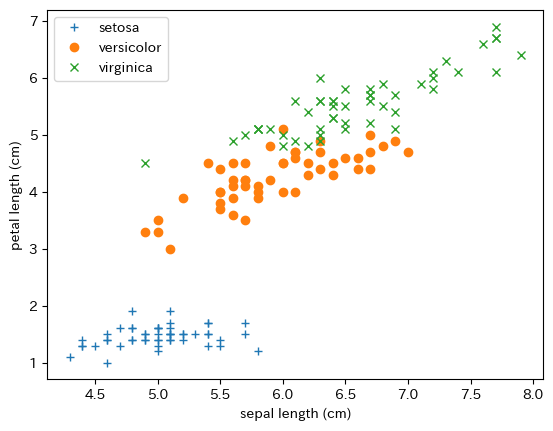

In [7]:
# 散布図の作成
plt.plot(df_x[df_iris['iris name'] == 'setosa']['sepal length (cm)'], df_x[df_iris['iris name'] == 'setosa']['petal length (cm)'], '+', label='setosa')
plt.plot(df_x[df_iris['iris name'] == 'versicolor']['sepal length (cm)'], df_x[df_iris['iris name'] == 'versicolor']['petal length (cm)'], 'o', label='versicolor')
plt.plot(df_x[df_iris['iris name'] == 'virginica']['sepal length (cm)'], df_x[df_iris['iris name'] == 'virginica']['petal length (cm)'], 'x', label='virginica')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')
plt.legend()


## 2. モデルの定義

In [8]:
# 入力データと次元数
inputs = t_x_train
n_input = t_x_train.shape[1]

# 正解データと出力次元数
labels = t_y_train
labels = labels.view(-1) # 損失関数の都合上、1次元に変換する必要がある。
t_y_test = t_y_test.view(-1)

n_output = len(list(set(df_y_train['iris kind'])))

# モデルの定義,softmax関数は損失関数に含まれるため不要。つまり線形関数のみで良い。
class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)
    
    def forward(self, x):
        x = self.l1(x)
        return x

# モデルのインスタンス化
net = Net(n_input, n_output)

# モデルのパラメータを表示する
for param in net.parameters():
    print(param)
        

Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True)
Parameter containing:
tensor([1., 1., 1.], requires_grad=True)


## 3. 損失関数と最適化アルゴリズムの選択

In [9]:
# 損失関数の定義(本来はsoftmax関数は予測関数側に含まれるが、nn.CrossEntropyLoss()には含まれているため不要)
# pytorchは対数関数と指数関数は同時に使うべきという信念があるため、信念に従って同時に使っているnn.CrossEntropyLoss()を使う。
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化手法の定義、勾配降下法を使用する。
optimizer = optim.SGD(net.parameters(), lr=lr)

## (extra 1.) 計算グラフの図示

形状は torch.Size([75, 3])
変数名 :  outputs  変数型は  <class 'torch.Tensor'>


,0,1,2
0,13.6,13.6,13.6
1,10.4,10.4,10.4
2,12.0,12.0,12.0
3,11.5,11.5,11.5
4,10.9,10.9,10.9


形状は torch.Size([75])
変数名 :  labels  変数型は  <class 'torch.Tensor'>


,0
0,2
1,2
2,2
3,1
4,1


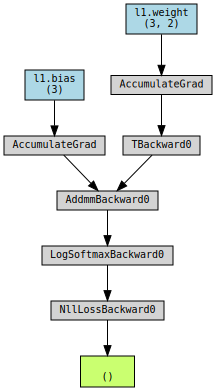

In [10]:

# 予測計算
outputs = net(inputs)

display_custom(outputs,labels)
# 損失計算
loss = criterion(outputs, labels)

#計算グラフの作成
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 4. モデルの学習

In [11]:
# くり返し回数
n_epoch = 10000

# 評価結果を格納するリスト
history = np.zeros((0,5))

In [12]:
# くり返し回数分学習を繰り返す
for epoch in range(n_epoch):
    # 勾配を初期化する
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs,labels)

    # 勾配計算
    loss.backward()

    # パラメータ更新
    optimizer.step()

    if ( (epoch) % 100 == 0):
        # 予測計算をラベルにする。
        _, predicted = torch.max(outputs, 1)

        # 訓練データの損失と精度を計算する
        loss_train = loss.item()
        acc_train = (predicted == labels).sum().item() / len(labels)

        # テストデータの損失と精度を計算する
        loss_test = criterion(net(t_x_test), t_y_test).item()
        _, predicted_test = torch.max(net(t_x_test), 1)
        acc_test = (predicted_test == t_y_test).sum().item() / len(t_y_test)
        
        # historyに結果を格納する
        history = np.vstack((history, np.array([epoch, loss_train, acc_train, loss_test, acc_test])))

        # 結果を表示する
        print('epoch: {}/{}, loss_train: {:.4f}, acc_train: {:.4f}, loss_test: {:.4f}, acc_test: {:.4f}'.format(epoch,n_epoch,loss_train, acc_train, loss_test, acc_test))


epoch: 0/10000, loss_train: 1.0986, acc_train: 0.3600, loss_test: 1.0891, acc_test: 0.3200
epoch: 100/10000, loss_train: 0.7934, acc_train: 0.7067, loss_test: 0.8189, acc_test: 0.6267
epoch: 200/10000, loss_train: 0.6600, acc_train: 0.7067, loss_test: 0.6953, acc_test: 0.6267
epoch: 300/10000, loss_train: 0.5866, acc_train: 0.7200, loss_test: 0.6260, acc_test: 0.6400
epoch: 400/10000, loss_train: 0.5399, acc_train: 0.7333, loss_test: 0.5810, acc_test: 0.6667
epoch: 500/10000, loss_train: 0.5069, acc_train: 0.7733, loss_test: 0.5488, acc_test: 0.7200
epoch: 600/10000, loss_train: 0.4818, acc_train: 0.8000, loss_test: 0.5240, acc_test: 0.7467
epoch: 700/10000, loss_train: 0.4617, acc_train: 0.8400, loss_test: 0.5039, acc_test: 0.7600
epoch: 800/10000, loss_train: 0.4450, acc_train: 0.8667, loss_test: 0.4869, acc_test: 0.7733
epoch: 900/10000, loss_train: 0.4306, acc_train: 0.8800, loss_test: 0.4723, acc_test: 0.8267
epoch: 1000/10000, loss_train: 0.4181, acc_train: 0.8800, loss_test: 0.4

In [13]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.08912 精度: 0.32000
最終状態: 損失: 0.22161 精度: 0.92000


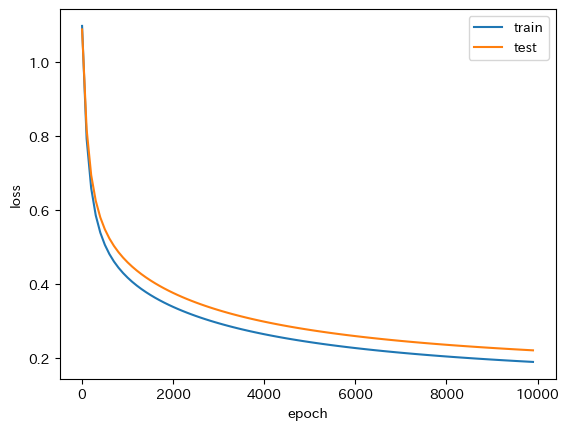

In [15]:
# 学習曲線の表示(損失)
plt.plot(history[:,0], history[:,1], label='train')
plt.plot(history[:,0], history[:,3], label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

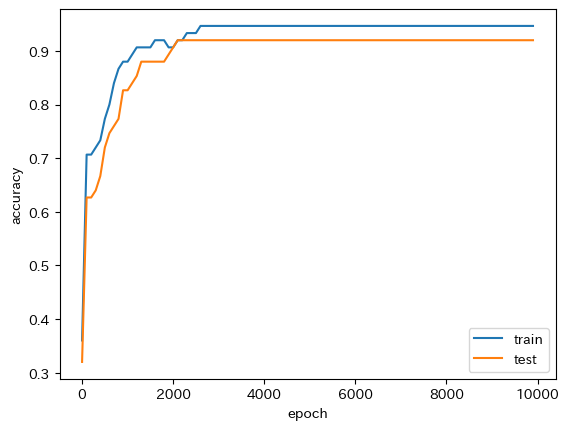

In [16]:
# 学習曲線の表示(精度)
plt.plot(history[:,0], history[:,2], label='train')
plt.plot(history[:,0], history[:,4], label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()